## Section 3 - Preparing Data for Regression

### Step 3.1 - Cleaning & Preparation of Dataset with selected parameters

#### Copying the cleaning part from first notebook. Here we are not taking Weekly Sales in the dataframe.

In [1]:
#Steps 1 & 2: Creating final dataset by merging various available datasets
#Merging features & stores stores
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
traintransform = pd.merge(features,stores, on ="Store",how="left")

In [2]:
finaltest = pd.merge(traintransform,test, on =["Store","Date","IsHoliday"],how="inner")

In [3]:
#Merging above dataset with train to create final dataset
finaltrain = pd.merge(traintransform,train, on =["Store","Date","IsHoliday"],how="inner")

In [4]:
#Converting Date to datetime format
finaltrain['Date'] =  pd.to_datetime(finaltrain['Date'])
finaltest['Date'] = pd.to_datetime(finaltest['Date'])

In [5]:
#This shows we only have null data in "Markdown". We are filling it with "NaN" values for further analysis.
df=finaltrain.fillna(0)
finaltest = finaltest.fillna(0)

In [6]:
# sorting data with respect to date
df = df.sort_values(by='Date')
finaltest = finaltest.sort_values(by='Date')

In [7]:
df = pd.get_dummies(df, columns=['Type'], drop_first = False)
finaltest = pd.get_dummies(finaltest, columns=['Type'], drop_first=False)

#### As observed during analysis 5 - Holiday vs Weekly sales, data doesn't consider pre-christmas as holiday even though it has significant impact on weekly sales. Thus, we are adding a new parameter to the model - "Days to Next Christmas".

In [8]:
# Add column for year
df["Year"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.year
finaltest["Year"] = pd.to_datetime(finaltest["Date"], format="%Y-%m-%d").dt.year
# Add column for day
df["Day"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.day
finaltest["Day"] = pd.to_datetime(finaltest["Date"], format="%Y-%m-%d").dt.day
# Add column for days to next Christmas
df["Days to Next Christmas"] = (pd.to_datetime(df["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
finaltest["Days to Next Christmas"] = (pd.to_datetime(finaltest["Year"].astype(str) + "-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(finaltest["Date"], format="%Y-%m-%d")).dt.days.astype(int)

#### As we observed during analysis that some parameters do not have an impact on weekly sales, we are dropping those for further traning of model.

Parameters being dropped:

Temperature

Fuel Price

CPI

Unemployment

Date (As we've converted date to individual elements above)

In [9]:
df = df.drop("Date",axis=1)
df = df.drop("CPI",axis=1)
df = df.drop("Temperature",axis=1)
df = df.drop("Fuel_Price",axis=1)
df = df.drop("Unemployment",axis=1)
finaltest = finaltest.drop("Date",axis=1)
finaltest = finaltest.drop("CPI",axis=1)
finaltest = finaltest.drop("Unemployment",axis=1)
finaltest = finaltest.drop("Temperature",axis=1)
finaltest = finaltest.drop("Fuel_Price",axis=1)

In [10]:
y = df.Weekly_Sales

In [11]:
df = df.drop("Weekly_Sales",axis=1)

### Step 3.2 - Splitting data into train & validation datasets

Splitting data in 8:2 ratio as train and validation. We will build the model on train data and use validation data to check for accuracy of different models.

In [12]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(337256, 15) (337256,)
(84314, 15) (84314,)


In [13]:
X_train.head(2)

,Store,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Type_A,Type_B,Type_C,Year,Day,Days to Next Christmas
195122,20,10686.42,750.14,3.67,3867.16,3518.62,False,203742,3,1,0,0,2012,9,297
106480,11,11984.13,191.40,78.65,2768.31,6358.77,False,207499,97,1,0,0,2012,8,206


In [14]:
y_train.head(2)

195122    13701.90
106480    18347.26
Name: Weekly_Sales, dtype: float64

In [15]:
X_test.head(2)

,Store,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Type_A,Type_B,Type_C,Year,Day,Days to Next Christmas
320406,33,33.23,0.0,0.0,0.0,590.43,False,39690,9,1,0,0,2012,12,80
51621,6,0.00,0.0,0.0,0.0,0.00,False,202505,83,1,0,0,2010,5,56


In [16]:
y_test.head(2)

320406      22.72
51621     3530.56
Name: Weekly_Sales, dtype: float64

In [17]:
finaltest.head(2)

,Store,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Type_A,Type_B,Type_C,Year,Day,Days to Next Christmas
0,1,6766.44,5147.70,50.82,3639.90,2737.42,False,151315,1,1,0,0,2012,2,59
37648,15,4565.57,5904.29,9.00,1437.77,1226.03,False,123737,74,0,1,0,2012,2,59


## Section 4 - Regression Models

### 4.1 - K Nearest Neighbour Regression Model

In [18]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
finaltestpred = sc_X.transform(finaltest) 

In [19]:
#Running KNN model
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10,n_jobs=4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

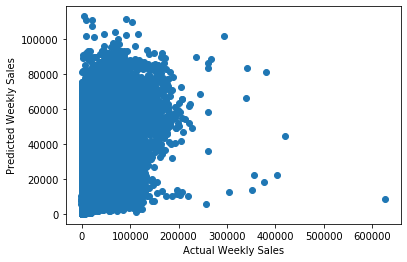

In [20]:
# Plotting predicted vs actual weekly sales
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

#### We can't see a clear trend between weekly sales predicted values and actual values here.

In [21]:
import sklearn.metrics as metrics

In [22]:
#Calculating different errors to check accuracy of model - MAE & RMSE 
print(metrics.mean_absolute_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

12015.652518442965
19458.73689220347


In [23]:
#Calculating accuracy of model
accuracy = knn.score(X_test,y_test)
print("Accuracy of KNN model = " + str(accuracy * 100) + "%")

Accuracy of KNN model = 26.950389341813576%


#### As we can see, for KNN model, errors are very high & accuracy is low.

### 4.2 - Decision Tree Model

In [24]:
#Running Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train,y_train)
y_pred2 = dt.predict(X_test)

In [25]:
#Checking errors of model
print(metrics.mean_absolute_error(y_test,y_pred2))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred2)))

1721.426267760989
4437.943885565558


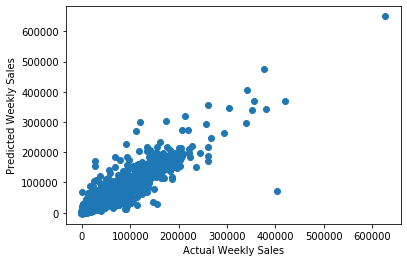

In [26]:
#Plotting predicted vs actual weekly sales
plt.scatter(y_test,y_pred2)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

#### We can see a clear linear trend between predicted and actual weekly sales.

In [27]:
#Calculating accuracy of model
accuracy2 = dt.score(X_test,y_test)
print("Accuracy of model is " + str(accuracy2 * 100) + "%")

Accuracy of model is 96.2002744684469%


#### As seen, Decision Tree model has good accuracy and considerably low error values. So, we'll consider this model.

### 4.3 - Random Forest Regressor

In [28]:
# Running model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 400,max_depth=15,n_jobs=5)        
rfr.fit(X_train,y_train)
y_pred3=rfr.predict(X_test)

In [31]:
#Checking errors
print(metrics.mean_absolute_error(y_test,y_pred3))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred3)))

1963.9395748385984
4415.946295000773


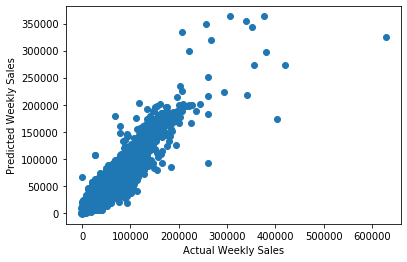

In [32]:
#Plotting predicted vs actual weekly sales
plt.scatter(y_test,y_pred3)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

#### We can see a clear trend between predicted weekly sales and actual weekly sales.

In [33]:
#Checking accuracy of model
accuracy3 = rfr.score(X_test,y_test)
print("Accuracy of Random Forrest model is " + str(accuracy3 * 100) + str("%"))

Accuracy of Random Forrest model is 96.23784937066524%


#### As seen, Random Forest model has good accuracy and considerably low error values. So, we'll consider this model.

### 4.4 XGB Regression

In [34]:
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor

In [35]:
#Running model
xgb_clf = XGBRegressor(objective='reg:linear', nthread= 4, n_estimators= 500, max_depth= 6, learning_rate= 0.5) 
xb = xgb_clf.fit(X_train,y_train)
y_pred4=xgb_clf.predict(X_test)

C:\Users\sushi\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:24:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
#Calculating error
print(metrics.mean_absolute_error(y_test,y_pred4))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred4)))

1893.9143747524101
3818.291662612698


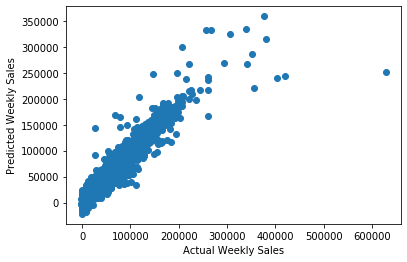

In [37]:
#Plotting actual vs predicted values
plt.scatter(y_test,y_pred4)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

#### We can see a clear trend between predicted and actual values.

In [38]:
accuracy4 = xb.score(X_test,y_test)
print("Accuracy of model is " + str(accuracy4*100) + "%")

Accuracy of model is 97.1872779863862%


#### As seen, XGB model has good accuracy and considerably low error values. So, we'll consider this model.

### 4.5 - Extra Trees Regression

In [45]:
#Running model
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=30,n_jobs=4) 
etr.fit(X_train,y_train)
y_pred5=etr.predict(X_test)

In [46]:
#Finding errors
print(metrics.mean_absolute_error(y_test,y_pred5))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred5)))

1418.1561235895977
4041.8466649110655


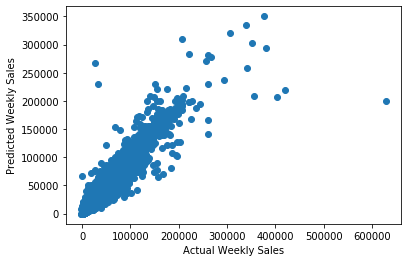

In [47]:
#Plotting predicted vs actual sales
plt.scatter(y_test,y_pred5)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

#### We can see a clear trend, thus the Extra Tree model is considered for final predictions

In [48]:
accuracy5 = etr.score(X_test,y_test)
print("Accuracy of model = " + str(accuracy5*100) + "%")

Accuracy of model = 96.8482752568195%


#### As seen, Extra Trees model has good accuracy and considerably low error values. So, we'll consider this model.

In [50]:
#Summary of all models with errors and accuracy
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model", "MAE", "RMSE", "Accuracy"]
x.add_row(["KNNRegressor",12045.12,19569.96,26])
x.add_row(["DecisionTreeRegressor", 1680.46,4009.80,96.91])
x.add_row(["RandomForestRegressor", 1940.60,4076.22,96.81])
x.add_row(["XGBRegressor", 1831.50,3485.78,97.66])
x.add_row(["ExtraTreeRegressor", 1376.63,3540.73,97.59])
print(x)

+-----------------------+----------+----------+----------+
|         Model         |   MAE    |   RMSE   | Accuracy |
+-----------------------+----------+----------+----------+
|      KNNRegressor     | 12045.12 | 19569.96 |    26    |
| DecisionTreeRegressor | 1680.46  |  4009.8  |  96.91   |
| RandomForestRegressor |  1940.6  | 4076.22  |  96.81   |
|      XGBRegressor     |  1831.5  | 3485.78  |  97.66   |
|   ExtraTreeRegressor  | 1376.63  | 3540.73  |  97.59   |
+-----------------------+----------+----------+----------+


## CONCLUSION:

#### As seen in the above table, XGB Regression model has the highest accuracy. It also has considerably low values for error as compared to other models. Thus we will use this model to predict sales for the test set.

In [51]:
#Predicting on Final test set (without weekly sales)
xgb_clf_pred=xgb_clf.predict(finaltestpred)

In [52]:
#Final dataframe with Predicted weekly sales
finalprediction = pd.DataFrame(xgb_clf_pred)

In [53]:
finalprediction=finalprediction.reset_index(drop=True)

In [54]:
horizontal_stack = pd.concat([finaltest, finalprediction], axis=1)

In [55]:
horizontal_stack.rename(columns={0: 'Predicted Weekly Sales'}, inplace=True)

In [56]:
horizontal_stack.head(5)

,Store,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Type_A,Type_B,Type_C,Year,Day,Days to Next Christmas,Predicted Weekly Sales
0,1,6766.44,5147.7,50.82,3639.9,2737.42,False,151315,1,1,0,0,2012,2,59,39585.613281
1,1,6766.44,5147.7,50.82,3639.9,2737.42,False,151315,2,1,0,0,2012,2,59,11341.232422
2,1,6766.44,5147.7,50.82,3639.9,2737.42,False,151315,3,1,0,0,2012,2,59,35597.195312
3,1,6766.44,5147.7,50.82,3639.9,2737.42,False,151315,4,1,0,0,2012,2,59,4917.603027
4,1,6766.44,5147.7,50.82,3639.9,2737.42,False,151315,5,1,0,0,2012,2,59,4314.440918
